# This notebook provides the functionality to analyse the network sensitivity.


In [1]:
import pylab as pl
import datetime
import pandas as pd
import itertools
from itertools import cycle
import pickle
import random as rn
import os
from time import time
from tqdm import tqdm

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils import resample

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras import layers, metrics
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import model_from_json, load_model
from keras.regularizers import *
from keras.callbacks import CSVLogger
from keras import backend as K

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/josh/anaconda3/envs/mosquitoes/lib

In [2]:
# rand_seed = np.random.randint(low=0, high=100)
rand_seed = 16
print(rand_seed)

16


In [3]:
os.environ['PYTHONHASHSEED'] = '0'

## The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
np.random.seed(42)

## The below is necessary for starting core Python generated random numbers in a well-defined state.
rn.seed(12345)

## Force TensorFlow to use single thread.
## Multiple threads are a potential source of
## non-reproducible results.
## For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res
# session_conf = tf.ConfigProto(device_count = {'GPU':0}, intra_op_parallelism_threads=4) #session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# session_conf = tf.ConfigProto(device_count = {'GPU':0}) #session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#session_conf.gpu_options.per_process_gpu_memory_fraction = 0.5
## The below tf.set_random_seed() will make random number generation
## in the TensorFlow backend have a well-defined initial state.
## For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(1234)

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.35)

sess = tf.Session(graph=tf.get_default_graph(), config=tf.ConfigProto(gpu_options=gpu_options))
K.set_session(sess)

## Load the data

The data file is created using Loco Mosquito:
https://github.com/magonji/MIMI-project/blob/master/Loco%20mosquito%204.0.ipynb

### The data file has headings: Species - Status - RearCnd - Age - Country- Frequencies

In [4]:
df = pd.read_csv("../../Data//mosquitoes_country_LM_5_0.dat", '\t')
df.head(10)
RearCnd_counts = df.groupby('RearCnd').size()

df['AgeGroup'] = 0
df['AgeGroup'] = np.where(df['Age']>10, 2, np.where(df['Age']>4, 1, 0))

df_vf = df[df['RearCnd']=='VF']
df_vf = df_vf[df_vf['Status']=='UN']
df = df[df['RearCnd']!='VF']
df = df[df['Status']!='UN']
df_l = df[df['RearCnd']=='TL']
df_l_g = df_l[df_l['Country']=='S']
df_l_g_a = df_l_g[df_l_g['Species']=='AA']
age_counts = df_l_g_a.groupby('AgeGroup').size()
df_l_g_g = df_l_g[df_l_g['Species']=='AG']
age_counts = df_l_g_g.groupby('AgeGroup').size()
df_l_g_c = df_l_g[df_l_g['Species']=='AC']
age_counts = df_l_g_c.groupby('AgeGroup').size()
df_l_t = df_l[df_l['Country']=='T']
df_l_t_a = df_l_t[df_l_t['Species']=='AA']
age_counts = df_l_t_a.groupby('AgeGroup').size()
df_l_t_g = df_l_t[df_l_t['Species']=='AG']
age_counts = df_l_t_g.groupby('AgeGroup').size()
df_l_b = df_l[df_l['Country']=='B']
df_l_b_g = df_l_b[df_l_b['Species']=='AG']
age_counts = df_l_b_g.groupby('AgeGroup').size()
df_l_b_c = df_l_b[df_l_b['Species']=='AC']
age_counts = df_l_b_c.groupby('AgeGroup').size()
df_f = df[df['RearCnd']=='TF']
df_f_t = df_f[df_f['Country']=='T']
df_f_t_a = df_f_t[df_f_t['Species']=='AA']
age_counts = df_f_t_a.groupby('AgeGroup').size()
# df_f_t_g = df_f_t[df_f_t['Species']=='AG'] #There isn't any
df_f_b = df_f[df_f['Country']=='B']
df_f_b_g = df_f_b[df_f_b['Species']=='AG']
age_counts = df_f_b_g.groupby('AgeGroup').size()
df_f_b_c = df_f_b[df_f_b['Species']=='AC']
age_counts = df_f_b_c.groupby('AgeGroup').size()
df_vf_t = df_vf[df_vf['Country']=='T']
df_vf_t_a = df_vf_t[df_vf_t['Species']=='AA']
age_counts = df_vf_t_a.groupby('AgeGroup').size()
df_vf_t_g = df_vf_t[df_vf_t['Species']=='AG']
age_counts = df_vf_t_g.groupby('AgeGroup').size()
df_vf_b = df_vf[df_vf['Country']=='B']
df_vf_b_g = df_vf_b[df_vf_b['Species']=='AG']
age_counts = df_vf_b_g.groupby('AgeGroup').size()
df_vf_b_c = df_vf_b[df_vf_b['Species']=='AC']
age_counts = df_vf_b_c.groupby('AgeGroup').size()

size_inc = 400
for age in range(3):
    df_temp = df_l_t_a[df_l_t_a['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(42)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    if age == 0:
        df_train = df_temp.iloc[index_df_temp_inc]
#         df_test = df_temp.iloc[index_df_temp_not_inc]
    else:
        df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#         df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
for age in range(3):
    df_temp = df_l_t_g[df_l_t_g['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(42)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
size_inc = 400
for age in range(3):
    df_temp = df_l_b_g[df_l_b_g['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(42)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
for age in range(3):
    df_temp = df_l_b_c[df_l_b_c['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(42)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
size_inc = 300 # 50
for age in range(3):
    df_temp = df_f_t_a[df_f_t_a['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(42)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    if age == 0:
        df_trainf = df_temp.iloc[index_df_temp_inc]
#         df_test = df_temp.iloc[index_df_temp_not_inc]
    else:
        df_trainf = pd.concat([df_trainf, df_temp.iloc[index_df_temp_inc]])
#     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
for age in range(3):
    df_temp = df_f_b_g[df_f_b_g['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(42)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    df_trainf = pd.concat([df_trainf, df_temp.iloc[index_df_temp_inc]])
#     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
for age in range(3):
    df_temp = df_f_b_c[df_f_b_c['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(42)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    df_trainf = pd.concat([df_trainf, df_temp.iloc[index_df_temp_inc]])
#     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
size_inc = 0
for age in range(3):
    df_temp = df_vf_t_a[df_vf_t_a['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(42)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
    if age == 0:
        df_test = df_temp.iloc[index_df_temp_not_inc]
    else:
        df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
for age in range(3):
    df_temp = df_vf_t_g[df_vf_t_g['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(42)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
    df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
size_inc = 0
for age in range(3):
    df_temp = df_vf_b_g[df_vf_b_g['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(42)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
    df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
for age in range(3):
    df_temp = df_vf_b_c[df_vf_b_c['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(42)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
    df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])

X = df_train.iloc[:,6:-1]
y_age = df_train["Age"]
y_age_groups = df_train["AgeGroup"]
y_species = df_train["Species"]
y_status = df_train["Status"]
X = np.asarray(X)
y_age = np.asarray(y_age)
y_age_groups = np.asarray(y_age_groups)
y_species = np.asarray(y_species)
y_status = np.asarray(y_status)

print('shape of X : {}'.format(X.shape))
print('shape of y age : {}'.format(y_age.shape))
print('shape of y age groups : {}'.format(y_age_groups.shape))
print('shape of y species : {}'.format(y_species.shape))
print('shape of y status : {}'.format(y_status.shape))

Xf = df_trainf.iloc[:,6:-1]
y_agef = df_trainf["Age"]
y_age_groupsf = df_trainf["AgeGroup"]
y_speciesf = df_trainf["Species"]
y_statusf = df_trainf["Status"]
Xf = np.asarray(Xf)
y_agef = np.asarray(y_agef)
y_age_groupsf = np.asarray(y_age_groupsf)
y_speciesf = np.asarray(y_speciesf)
y_statusf = np.asarray(y_statusf)

print('shape of X f : {}'.format(Xf.shape))
print('shape of y age f : {}'.format(y_agef.shape))
print('shape of y age groups f : {}'.format(y_age_groupsf.shape))
print('shape of y species f : {}'.format(y_speciesf.shape))
print('shape of y status f : {}'.format(y_statusf.shape))

X_vf = df_test.iloc[:,6:-1]
y_age_vf = df_test["Age"]
y_age_groups_vf = df_test["AgeGroup"]
y_species_vf = df_test["Species"]
y_status_vf = df_test["Status"]
X_vf = np.asarray(X_vf)
y_age_vf = np.asarray(y_age_vf)
y_age_groups_vf = np.asarray(y_age_groups_vf)
y_species_vf = np.asarray(y_species_vf)
y_status_vf = np.asarray(y_status_vf)
print('shape of X vf : {}'.format(X_vf.shape))



shape of X : (4800, 1625)
shape of y age : (4800,)
shape of y age groups : (4800,)
shape of y species : (4800,)
shape of y status : (4800,)
shape of X f : (2400, 1625)
shape of y age f : (2400,)
shape of y age groups f : (2400,)
shape of y species f : (2400,)
shape of y status f : (2400,)
shape of X vf : (3277, 1625)


## Sensitivity Analysis

In [6]:
from keras.models import Model

outdir = "../CNN/CNN/Results_Paper/"
loaddir = (outdir+"Trian_Lab_Field_V2/")
model = load_model((loaddir+"Baseline_CNN_Model.h5"))
for layer in model.layers:
    layer.trainable = False

In [14]:
from keras.models import Model

outdir = "../MLP/Results_Paper/"
loaddir = (outdir+"Trian_Lab_Field_V2/")
model = load_model((loaddir+"Baseline_CNN_Model.h5"))
for layer in model.layers:
    layer.trainable = False

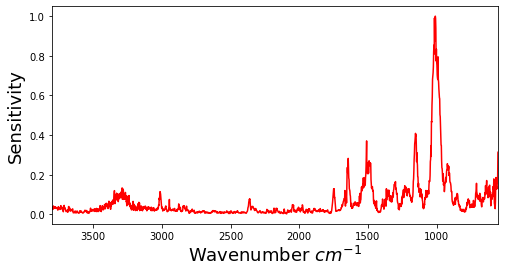

In [15]:

df1 = df_train[df_train['AgeGroup']==0]
df1f = df_trainf[df_trainf['AgeGroup']==0]
X1l= df1.iloc[:,6:-1]
X1f = df1f.iloc[:,6:-1]
X_plot = np.asarray(X1l)
scl = StandardScaler()
features_scl = scl.fit(X=np.vstack((X1l,X1f)))
X1 = features_scl.transform(X=np.vstack((X1l,X1f)))
X1 = np.asarray(X1)

layer_output = model.get_layer('age_group').output

loss = layer_output[:, 0]
    
grads = K.gradients(loss, model.layers[0].input)[0]
iterate = K.function([model.layers[0].input], [loss, grads])

grads_out = np.zeros((X1.shape[0],1625))
for i in range(X1.shape[0]):
    img = X1[i]
    img = np.expand_dims(img, axis=0)
    img = np.expand_dims(img, axis=2)

    loss_value, grads_value = iterate([img])
    grads_value[grads_value<0] = 0
    grads_value = grads_value[0]
    grads_value = np.squeeze(grads_value)*np.squeeze(scl.scale_) 
    grads_out[i,:] += np.squeeze(grads_value)


grads_out_mean = np.mean(grads_out, axis=0)
grads_out_std = np.std(grads_out, axis=0)


fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)
l1 = plt.plot(np.arange(3800, 550, -2), np.squeeze(grads_out_mean)/np.max(grads_out_mean), c='r')

## Bands
# plt.fill_between([3650,3100],[np.max(grads_out_mean),np.max(grads_out_mean)], color='b', alpha=0.2)
# plt.fill_between([3400,3000],[np.max(grads_out_mean),np.max(grads_out_mean)], color='r', alpha=0.2)
# plt.fill_between([3050,2750],[np.max(grads_out_mean),np.max(grads_out_mean)], color='g', alpha=0.2)
# plt.fill_between([1800,1650],[np.max(grads_out_mean),np.max(grads_out_mean)], color='r', alpha=0.2)
# plt.fill_between([1750,1600],[np.max(grads_out_mean),np.max(grads_out_mean)], color='y', alpha=0.2)
# plt.fill_between([1600,1475],[np.max(grads_out_mean),np.max(grads_out_mean)], color='y', alpha=0.2)
# plt.fill_between([1500,1300],[np.max(grads_out_mean),np.max(grads_out_mean)], color='g', alpha=0.2)
# plt.fill_between([1350,1200],[np.max(grads_out_mean),np.max(grads_out_mean)], color='y', alpha=0.2)
# plt.fill_between([1200,900],[np.max(grads_out_mean),np.max(grads_out_mean)], color='r', alpha=0.2)
# plt.fill_between([775,700],[np.max(grads_out_mean),np.max(grads_out_mean)], color='g', alpha=0.2)
# plt.fill_between([725,650],[np.max(grads_out_mean),np.max(grads_out_mean)], color='r', alpha=0.2)
## Bands
# plt.fill_between([3650,3100],[1,1], color='b', alpha=0.2)
# plt.fill_between([3400,3000],[1,1], color='r', alpha=0.2)
# plt.fill_between([3050,2750],[1,1], color='g', alpha=0.2)
# plt.fill_between([1800,1650],[1,1], color='r', alpha=0.2)
# plt.fill_between([1750,1600],[1,1], color='y', alpha=0.2)
# plt.fill_between([1600,1475],[1,1], color='y', alpha=0.2)
# plt.fill_between([1500,1300],[1,1], color='g', alpha=0.2)
# plt.fill_between([1350,1200],[1,1], color='y', alpha=0.2)
# plt.fill_between([1200,900],[1,1], color='r', alpha=0.2)
# plt.fill_between([775,700],[1,1], color='g', alpha=0.2)
# plt.fill_between([725,650],[1,1], color='r', alpha=0.2)

# l1 = plt.plot(np.arange(3800, 550, -2), np.squeeze((X_plot[0] - np.min(X_plot[0]))/(np.max(X_plot[0])-np.min(X_plot[0]))), c='k')

ax.set_xlim(3800, 550)
ax.set_xlabel('Wavenumber $cm^{-1}$', fontsize=18)
ax.set_ylabel('Sensitivity', fontsize=18)
# plt.savefig('sensitivity/age0.pdf')
plt.savefig('sensitivity_mlp/age0.pdf')


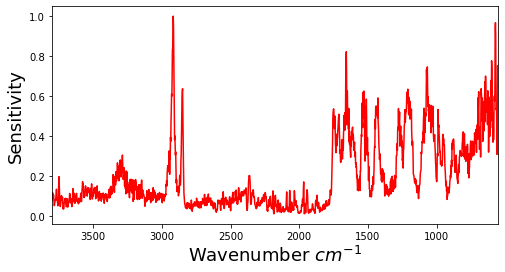

In [16]:

df1 = df_train[df_train['AgeGroup']==1]
df1f = df_trainf[df_trainf['AgeGroup']==1]
X1l= df1.iloc[:,6:-1]
X1f = df1f.iloc[:,6:-1]
X_plot = np.asarray(X1l)
scl = StandardScaler()
features_scl = scl.fit(X=np.vstack((X1l,X1f)))
X1 = features_scl.transform(X=np.vstack((X1l,X1f)))
X1 = np.asarray(X1)

layer_output = model.get_layer('age_group').output

loss = layer_output[:, 1]
    
grads = K.gradients(loss, model.layers[0].input)[0]
iterate = K.function([model.layers[0].input], [loss, grads])

grads_out = np.zeros((X1.shape[0],1625))
for i in range(X1.shape[0]):
    img = X1[i]
    img = np.expand_dims(img, axis=0)
    img = np.expand_dims(img, axis=2)

    loss_value, grads_value = iterate([img])
    grads_value[grads_value<0] = 0
    grads_value = grads_value[0]
    grads_value = np.squeeze(grads_value)*np.squeeze(scl.scale_) 
    grads_out[i,:] += np.squeeze(grads_value)

grads_out_mean = np.mean(grads_out, axis=0)
grads_out_std = np.std(grads_out, axis=0)

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)
l1 = plt.plot(np.arange(3800, 550, -2), np.squeeze(grads_out_mean)/np.max(grads_out_mean), c='r')

## Bands
# plt.fill_between([3650,3100],[np.max(grads_out_mean),np.max(grads_out_mean)], color='b', alpha=0.2)
# plt.fill_between([3400,3000],[np.max(grads_out_mean),np.max(grads_out_mean)], color='r', alpha=0.2)
# plt.fill_between([3050,2750],[np.max(grads_out_mean),np.max(grads_out_mean)], color='g', alpha=0.2)
# plt.fill_between([1800,1650],[np.max(grads_out_mean),np.max(grads_out_mean)], color='r', alpha=0.2)
# plt.fill_between([1750,1600],[np.max(grads_out_mean),np.max(grads_out_mean)], color='y', alpha=0.2)
# plt.fill_between([1600,1475],[np.max(grads_out_mean),np.max(grads_out_mean)], color='y', alpha=0.2)
# plt.fill_between([1500,1300],[np.max(grads_out_mean),np.max(grads_out_mean)], color='g', alpha=0.2)
# plt.fill_between([1350,1200],[np.max(grads_out_mean),np.max(grads_out_mean)], color='y', alpha=0.2)
# plt.fill_between([1200,900],[np.max(grads_out_mean),np.max(grads_out_mean)], color='r', alpha=0.2)
# plt.fill_between([775,700],[np.max(grads_out_mean),np.max(grads_out_mean)], color='g', alpha=0.2)
# plt.fill_between([725,650],[np.max(grads_out_mean),np.max(grads_out_mean)], color='r', alpha=0.2)
## Bands
# plt.fill_between([3650,3100],[1,1], color='b', alpha=0.2)
# plt.fill_between([3400,3000],[1,1], color='r', alpha=0.2)
# plt.fill_between([3050,2750],[1,1], color='g', alpha=0.2)
# plt.fill_between([1800,1650],[1,1], color='r', alpha=0.2)
# plt.fill_between([1750,1600],[1,1], color='y', alpha=0.2)
# plt.fill_between([1600,1475],[1,1], color='y', alpha=0.2)
# plt.fill_between([1500,1300],[1,1], color='g', alpha=0.2)
# plt.fill_between([1350,1200],[1,1], color='y', alpha=0.2)
# plt.fill_between([1200,900],[1,1], color='r', alpha=0.2)
# plt.fill_between([775,700],[1,1], color='g', alpha=0.2)
# plt.fill_between([725,650],[1,1], color='r', alpha=0.2)

# l1 = plt.plot(np.arange(3800, 550, -2), np.squeeze((X_plot[0] - np.min(X_plot[0]))/(np.max(X_plot[0])-np.min(X_plot[0]))), c='k')

ax.set_xlim(3800, 550)
ax.set_xlabel('Wavenumber $cm^{-1}$', fontsize=18)
ax.set_ylabel('Sensitivity', fontsize=18)
# plt.savefig('sensitivity/age1.pdf')
plt.savefig('sensitivity_mlp/age1.pdf')

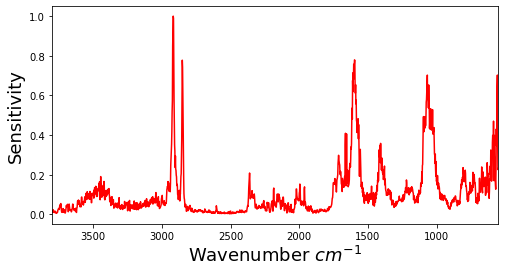

In [17]:

df1 = df_train[df_train['AgeGroup']==2]
df1f = df_trainf[df_trainf['AgeGroup']==2]
X1l= df1.iloc[:,6:-1]
X1f = df1f.iloc[:,6:-1]
X_plot = np.asarray(X1l)
scl = StandardScaler()
features_scl = scl.fit(X=np.vstack((X1l,X1f)))
X1 = features_scl.transform(X=np.vstack((X1l,X1f)))
X1 = np.asarray(X1)

layer_output = model.get_layer('age_group').output

loss = layer_output[:, 2]
    
grads = K.gradients(loss, model.layers[0].input)[0]
iterate = K.function([model.layers[0].input], [loss, grads])

grads_out = np.zeros((X1.shape[0],1625))
for i in range(X1.shape[0]):
    img = X1[i]
    img = np.expand_dims(img, axis=0)
    img = np.expand_dims(img, axis=2)

    loss_value, grads_value = iterate([img])
    grads_value[grads_value<0] = 0
    grads_value = grads_value[0]
    grads_value = np.squeeze(grads_value)*np.squeeze(scl.scale_) 
    grads_out[i,:] += np.squeeze(grads_value)

grads_out_mean = np.mean(grads_out, axis=0)
grads_out_std = np.std(grads_out, axis=0)

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)
l1 = plt.plot(np.arange(3800, 550, -2), np.squeeze(grads_out_mean)/np.max(grads_out_mean), c='r')

## Bands
# plt.fill_between([3650,3100],[np.max(grads_out_mean),np.max(grads_out_mean)], color='b', alpha=0.2)
# plt.fill_between([3400,3000],[np.max(grads_out_mean),np.max(grads_out_mean)], color='r', alpha=0.2)
# plt.fill_between([3050,2750],[np.max(grads_out_mean),np.max(grads_out_mean)], color='g', alpha=0.2)
# plt.fill_between([1800,1650],[np.max(grads_out_mean),np.max(grads_out_mean)], color='r', alpha=0.2)
# plt.fill_between([1750,1600],[np.max(grads_out_mean),np.max(grads_out_mean)], color='y', alpha=0.2)
# plt.fill_between([1600,1475],[np.max(grads_out_mean),np.max(grads_out_mean)], color='y', alpha=0.2)
# plt.fill_between([1500,1300],[np.max(grads_out_mean),np.max(grads_out_mean)], color='g', alpha=0.2)
# plt.fill_between([1350,1200],[np.max(grads_out_mean),np.max(grads_out_mean)], color='y', alpha=0.2)
# plt.fill_between([1200,900],[np.max(grads_out_mean),np.max(grads_out_mean)], color='r', alpha=0.2)
# plt.fill_between([775,700],[np.max(grads_out_mean),np.max(grads_out_mean)], color='g', alpha=0.2)
# plt.fill_between([725,650],[np.max(grads_out_mean),np.max(grads_out_mean)], color='r', alpha=0.2)
## Bands
# plt.fill_between([3650,3100],[1,1], color='b', alpha=0.2)
# plt.fill_between([3400,3000],[1,1], color='r', alpha=0.2)
# plt.fill_between([3050,2750],[1,1], color='g', alpha=0.2)
# plt.fill_between([1800,1650],[1,1], color='r', alpha=0.2)
# plt.fill_between([1750,1600],[1,1], color='y', alpha=0.2)
# plt.fill_between([1600,1475],[1,1], color='y', alpha=0.2)
# plt.fill_between([1500,1300],[1,1], color='g', alpha=0.2)
# plt.fill_between([1350,1200],[1,1], color='y', alpha=0.2)
# plt.fill_between([1200,900],[1,1], color='r', alpha=0.2)
# plt.fill_between([775,700],[1,1], color='g', alpha=0.2)
# plt.fill_between([725,650],[1,1], color='r', alpha=0.2)

# l1 = plt.plot(np.arange(3800, 550, -2), np.squeeze((X_plot[0] - np.min(X_plot[0]))/(np.max(X_plot[0])-np.min(X_plot[0]))), c='k')

ax.set_xlim(3800, 550)

ax.set_xlabel('Wavenumber $cm^{-1}$', fontsize=18)
ax.set_ylabel('Sensitivity', fontsize=18)
# plt.savefig('sensitivity/age2.pdf')
plt.savefig('sensitivity_mlp/age2.pdf')

#### Species

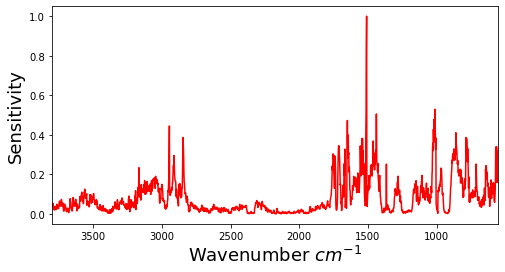

In [18]:

df1 = df_train[df_train['Species']=='AA']
df1f = df_trainf[df_trainf['Species']=='AA']
X1l= df1.iloc[:,6:-1]
X1f = df1f.iloc[:,6:-1]
X_plot = np.asarray(X1l)
scl = StandardScaler()
features_scl = scl.fit(X=np.vstack((X1l,X1f)))
X1 = features_scl.transform(X=np.vstack((X1l,X1f)))
X1 = np.asarray(X1)

layer_output = model.get_layer('species').output

loss = layer_output[:, 0]
    
grads = K.gradients(loss, model.layers[0].input)[0]
iterate = K.function([model.layers[0].input], [loss, grads])

grads_out = np.zeros((X1.shape[0],1625))
for i in range(X1.shape[0]):
    img = X1[i]
    img = np.expand_dims(img, axis=0)
    img = np.expand_dims(img, axis=2)

    loss_value, grads_value = iterate([img])
    grads_value[grads_value<0] = 0
    grads_value = grads_value[0]
    grads_value = np.squeeze(grads_value)*np.squeeze(scl.scale_) 
    grads_out[i,:] += np.squeeze(grads_value)

grads_out_mean = np.mean(grads_out, axis=0)
grads_out_std = np.std(grads_out, axis=0)

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)
l1 = plt.plot(np.arange(3800, 550, -2), np.squeeze(grads_out_mean)/np.max(grads_out_mean), c='r')

## Bands
# plt.fill_between([3650,3100],[np.max(grads_out_mean),np.max(grads_out_mean)], color='b', alpha=0.2)
# plt.fill_between([3400,3000],[np.max(grads_out_mean),np.max(grads_out_mean)], color='r', alpha=0.2)
# plt.fill_between([3050,2750],[np.max(grads_out_mean),np.max(grads_out_mean)], color='g', alpha=0.2)
# plt.fill_between([1800,1650],[np.max(grads_out_mean),np.max(grads_out_mean)], color='r', alpha=0.2)
# plt.fill_between([1750,1600],[np.max(grads_out_mean),np.max(grads_out_mean)], color='y', alpha=0.2)
# plt.fill_between([1600,1475],[np.max(grads_out_mean),np.max(grads_out_mean)], color='y', alpha=0.2)
# plt.fill_between([1500,1300],[np.max(grads_out_mean),np.max(grads_out_mean)], color='g', alpha=0.2)
# plt.fill_between([1350,1200],[np.max(grads_out_mean),np.max(grads_out_mean)], color='y', alpha=0.2)
# plt.fill_between([1200,900],[np.max(grads_out_mean),np.max(grads_out_mean)], color='r', alpha=0.2)
# plt.fill_between([775,700],[np.max(grads_out_mean),np.max(grads_out_mean)], color='g', alpha=0.2)
# plt.fill_between([725,650],[np.max(grads_out_mean),np.max(grads_out_mean)], color='r', alpha=0.2)
## Bands
# plt.fill_between([3650,3100],[1,1], color='b', alpha=0.2)
# plt.fill_between([3400,3000],[1,1], color='r', alpha=0.2)
# plt.fill_between([3050,2750],[1,1], color='g', alpha=0.2)
# plt.fill_between([1800,1650],[1,1], color='r', alpha=0.2)
# plt.fill_between([1750,1600],[1,1], color='y', alpha=0.2)
# plt.fill_between([1600,1475],[1,1], color='y', alpha=0.2)
# plt.fill_between([1500,1300],[1,1], color='g', alpha=0.2)
# plt.fill_between([1350,1200],[1,1], color='y', alpha=0.2)
# plt.fill_between([1200,900],[1,1], color='r', alpha=0.2)
# plt.fill_between([775,700],[1,1], color='g', alpha=0.2)
# plt.fill_between([725,650],[1,1], color='r', alpha=0.2)

# l1 = plt.plot(np.arange(3800, 550, -2), np.squeeze((X_plot[0] - np.min(X_plot[0]))/(np.max(X_plot[0])-np.min(X_plot[0]))), c='k')

ax.set_xlim(3800, 550)

ax.set_xlabel('Wavenumber $cm^{-1}$', fontsize=18)
ax.set_ylabel('Sensitivity', fontsize=18)
# plt.savefig('sensitivity/speciesAA.pdf')
plt.savefig('sensitivity_mlp/speciesAA.pdf')

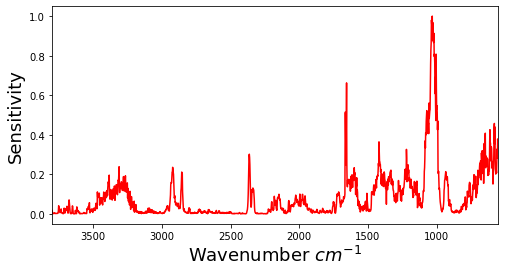

In [19]:

df1 = df_train[df_train['Species']=='AC']
df1f = df_trainf[df_trainf['Species']=='AC']
X1l= df1.iloc[:,6:-1]
X1f = df1f.iloc[:,6:-1]
X_plot = np.asarray(X1l)
scl = StandardScaler()
features_scl = scl.fit(X=np.vstack((X1l,X1f)))
X1 = features_scl.transform(X=np.vstack((X1l,X1f)))
X1 = np.asarray(X1)

layer_output = model.get_layer('species').output

loss = layer_output[:, 1]
    
grads = K.gradients(loss, model.layers[0].input)[0]
iterate = K.function([model.layers[0].input], [loss, grads])

grads_out = np.zeros((X1.shape[0],1625))
for i in range(X1.shape[0]):
    img = X1[i]
    img = np.expand_dims(img, axis=0)
    img = np.expand_dims(img, axis=2)

    loss_value, grads_value = iterate([img])
    grads_value[grads_value<0] = 0
    grads_value = grads_value[0]
    grads_value = np.squeeze(grads_value)*np.squeeze(scl.scale_) 
    grads_out[i,:] += np.squeeze(grads_value)

grads_out_mean = np.mean(grads_out, axis=0)
grads_out_std = np.std(grads_out, axis=0)

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)
l1 = plt.plot(np.arange(3800, 550, -2), np.squeeze(grads_out_mean)/np.max(grads_out_mean), c='r')

## Bands
# plt.fill_between([3650,3100],[np.max(grads_out_mean),np.max(grads_out_mean)], color='b', alpha=0.2)
# plt.fill_between([3400,3000],[np.max(grads_out_mean),np.max(grads_out_mean)], color='r', alpha=0.2)
# plt.fill_between([3050,2750],[np.max(grads_out_mean),np.max(grads_out_mean)], color='g', alpha=0.2)
# plt.fill_between([1800,1650],[np.max(grads_out_mean),np.max(grads_out_mean)], color='r', alpha=0.2)
# plt.fill_between([1750,1600],[np.max(grads_out_mean),np.max(grads_out_mean)], color='y', alpha=0.2)
# plt.fill_between([1600,1475],[np.max(grads_out_mean),np.max(grads_out_mean)], color='y', alpha=0.2)
# plt.fill_between([1500,1300],[np.max(grads_out_mean),np.max(grads_out_mean)], color='g', alpha=0.2)
# plt.fill_between([1350,1200],[np.max(grads_out_mean),np.max(grads_out_mean)], color='y', alpha=0.2)
# plt.fill_between([1200,900],[np.max(grads_out_mean),np.max(grads_out_mean)], color='r', alpha=0.2)
# plt.fill_between([775,700],[np.max(grads_out_mean),np.max(grads_out_mean)], color='g', alpha=0.2)
# plt.fill_between([725,650],[np.max(grads_out_mean),np.max(grads_out_mean)], color='r', alpha=0.2)
## Bands
# plt.fill_between([3650,3100],[1,1], color='b', alpha=0.2)
# plt.fill_between([3400,3000],[1,1], color='r', alpha=0.2)
# plt.fill_between([3050,2750],[1,1], color='g', alpha=0.2)
# plt.fill_between([1800,1650],[1,1], color='r', alpha=0.2)
# plt.fill_between([1750,1600],[1,1], color='y', alpha=0.2)
# plt.fill_between([1600,1475],[1,1], color='y', alpha=0.2)
# plt.fill_between([1500,1300],[1,1], color='g', alpha=0.2)
# plt.fill_between([1350,1200],[1,1], color='y', alpha=0.2)
# plt.fill_between([1200,900],[1,1], color='r', alpha=0.2)
# plt.fill_between([775,700],[1,1], color='g', alpha=0.2)
# plt.fill_between([725,650],[1,1], color='r', alpha=0.2)

# l1 = plt.plot(np.arange(3800, 550, -2), np.squeeze((X_plot[0] - np.min(X_plot[0]))/(np.max(X_plot[0])-np.min(X_plot[0]))), c='k')

ax.set_xlim(3800, 550)

ax.set_xlabel('Wavenumber $cm^{-1}$', fontsize=18)
ax.set_ylabel('Sensitivity', fontsize=18)
# plt.savefig('sensitivity/speciesAC.pdf')
plt.savefig('sensitivity_mlp/speciesAC.pdf')

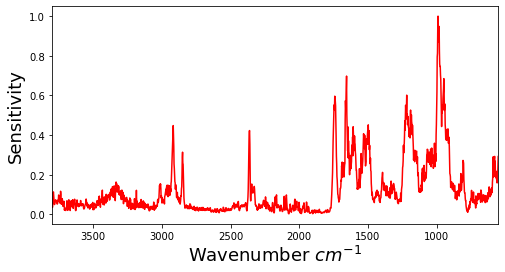

In [20]:

df1 = df_train[df_train['Species']=='AG']
df1f = df_trainf[df_trainf['Species']=='AG']
X1l= df1.iloc[:,6:-1]
X1f = df1f.iloc[:,6:-1]
X_plot = np.asarray(X1l)
scl = StandardScaler()
features_scl = scl.fit(X=np.vstack((X1l,X1f)))
X1 = features_scl.transform(X=np.vstack((X1l,X1f)))
X1 = np.asarray(X1)

layer_output = model.get_layer('species').output

loss = layer_output[:, 2]
    
grads = K.gradients(loss, model.layers[0].input)[0]
iterate = K.function([model.layers[0].input], [loss, grads])

grads_out = np.zeros((X1.shape[0],1625))
for i in range(X1.shape[0]):
    img = X1[i]
    img = np.expand_dims(img, axis=0)
    img = np.expand_dims(img, axis=2)

    loss_value, grads_value = iterate([img])
    grads_value[grads_value<0] = 0
    grads_value = grads_value[0]
    grads_value = np.squeeze(grads_value)*np.squeeze(scl.scale_) 
    grads_out[i,:] += np.squeeze(grads_value)

# print(grads_value)
grads_out_mean = np.mean(grads_out, axis=0)
grads_out_std = np.std(grads_out, axis=0)

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)
l1 = plt.plot(np.arange(3800, 550, -2), np.squeeze(grads_out_mean)/np.max(grads_out_mean), c='r')

## Bands
# plt.fill_between([3650,3100],[np.max(grads_out_mean),np.max(grads_out_mean)], color='b', alpha=0.2)
# plt.fill_between([3400,3000],[np.max(grads_out_mean),np.max(grads_out_mean)], color='r', alpha=0.2)
# plt.fill_between([3050,2750],[np.max(grads_out_mean),np.max(grads_out_mean)], color='g', alpha=0.2)
# plt.fill_between([1800,1650],[np.max(grads_out_mean),np.max(grads_out_mean)], color='r', alpha=0.2)
# plt.fill_between([1750,1600],[np.max(grads_out_mean),np.max(grads_out_mean)], color='y', alpha=0.2)
# plt.fill_between([1600,1475],[np.max(grads_out_mean),np.max(grads_out_mean)], color='y', alpha=0.2)
# plt.fill_between([1500,1300],[np.max(grads_out_mean),np.max(grads_out_mean)], color='g', alpha=0.2)
# plt.fill_between([1350,1200],[np.max(grads_out_mean),np.max(grads_out_mean)], color='y', alpha=0.2)
# plt.fill_between([1200,900],[np.max(grads_out_mean),np.max(grads_out_mean)], color='r', alpha=0.2)
# plt.fill_between([775,700],[np.max(grads_out_mean),np.max(grads_out_mean)], color='g', alpha=0.2)
# plt.fill_between([725,650],[np.max(grads_out_mean),np.max(grads_out_mean)], color='r', alpha=0.2)
## Bands
# plt.fill_between([3650,3100],[1,1], color='b', alpha=0.2)
# plt.fill_between([3400,3000],[1,1], color='r', alpha=0.2)
# plt.fill_between([3050,2750],[1,1], color='g', alpha=0.2)
# plt.fill_between([1800,1650],[1,1], color='r', alpha=0.2)
# plt.fill_between([1750,1600],[1,1], color='y', alpha=0.2)
# plt.fill_between([1600,1475],[1,1], color='y', alpha=0.2)
# plt.fill_between([1500,1300],[1,1], color='g', alpha=0.2)
# plt.fill_between([1350,1200],[1,1], color='y', alpha=0.2)
# plt.fill_between([1200,900],[1,1], color='r', alpha=0.2)
# plt.fill_between([775,700],[1,1], color='g', alpha=0.2)
# plt.fill_between([725,650],[1,1], color='r', alpha=0.2)

# l1 = plt.plot(np.arange(3800, 550, -2), np.squeeze((X_plot[0] - np.min(X_plot[0]))/(np.max(X_plot[0])-np.min(X_plot[0]))), c='k')

ax.set_xlim(3800, 550)

ax.set_xlabel('Wavenumber $cm^{-1}$', fontsize=18)
ax.set_ylabel('Sensitivity', fontsize=18)
# plt.savefig('sensitivity/speciesAG.pdf')
plt.savefig('sensitivity_mlp/speciesAG.pdf')